# Bias Variance Simulation / Regularization
This notebook demonstrates bias and variance using logistic regression.  It also demonstrates how regularization reduces variance.

In [1]:
%%bash
# Do not change or modify this cell
# Need to install pyspark
# if pyspark is already installed, will print a message indicating requirement already satisfied
pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for pyspark: filename=pyspark-3.3.0-py2.py3-none-any.whl size=281764026 sha256=6de540c0ffdd4f75c968bcd69ed526a36232e29084d67576742f49f9a4841865
  Stored in directory: /root/.cache/pip/wheels/7a/8e/1b/f73a52650d2e5f337708d9f6a1750d451a7349a867f928b885
Successfully built pyspark


In [2]:
from pyspark.sql import SparkSession
from pyspark.ml import feature, regression, Pipeline
from pyspark.sql import functions as fn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

Create some data that follows the following equation and add some noise:

$$
f(x)=10+5x+0.5x^2-0.1x^3
$$

In [3]:
# create numpy arrays for x and y data
x = np.linspace(-15, 15, 250)
y = 10 + 5*x + 0.5*np.square(x) - 0.1*np.power(x,3)

# note: The noise is just for show and is only used for visualization purposes
error = np.random.uniform(-50, 50, len(x))
y_noise = y + error

Text(0, 0.5, 'y, y_noise')

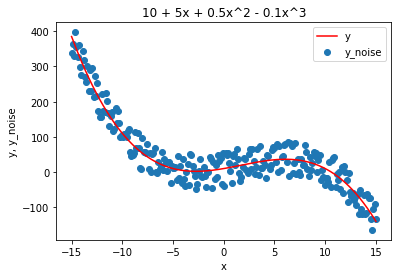

In [4]:
# plot x and y data
%matplotlib inline
plt.figure()
plt.plot(x,y, c='r', label="y")
plt.scatter(x, y_noise, label="y_noise")
plt.legend()
plt.title("10 + 5x + 0.5x^2 - 0.1x^3")
plt.xlabel("x")
plt.ylabel("y, y_noise")

Create pandas and spark dataframes from the cubic function data.

In [5]:
# create a pandas dataframe from the x, y, y_hat data arrays
pd_df = pd.DataFrame({'x': x, 'y_noise': y_noise, 'y_true': y})
pd_df.head()

,x,y_noise,y_true
0,-15.000000,337.890416,385.000000
1,-14.879518,363.760899,375.735055
2,-14.759036,328.703577,366.614220
3,-14.638554,397.189525,357.636445
4,-14.518072,354.446362,348.800681


In [6]:
# create a spark dataframe from the pandas dataframe
spark_df = spark.createDataFrame(pd_df)
spark_df.show()

+-------------------+------------------+------------------+
|                  x|           y_noise|            y_true|
+-------------------+------------------+------------------+
|              -15.0| 337.8904160912542|             385.0|
|-14.879518072289157| 363.7608990385707| 375.7350551866342|
|-14.759036144578314|328.70357726413295| 366.6142199805173|
| -14.63855421686747|397.18952461746363| 357.6364450398488|
|-14.518072289156626| 354.4463621219629|348.80068102282837|
|-14.397590361445783|326.65183127833086|340.10587858765587|
| -14.27710843373494|361.57794559700113|331.55098839253077|
|-14.156626506024097| 298.3724159586054| 323.1349610956528|
|-14.036144578313253| 275.4193918073014| 314.8567473552215|
| -13.91566265060241|344.91728409011984| 306.7152978294365|
|-13.795180722891565| 318.2442378243351| 298.7095631764975|
|-13.674698795180722|269.57668301404306| 290.8384940546042|
| -13.55421686746988| 256.1610350860861| 283.1010411219563|
|-13.433734939759036|300.56011088342217|

Define some convenience functions to make the analysis easier.

In [7]:
# To Do:  Add model bias and variance calculations 

# define a function which performs a poplynomial expansion of features
# args
#   n: The polynomial expansion degree
#   df: A spark dataframe containing the data on which to perform polynomial expansion.  The 
#       input data is expected to be in a col named 'x'
#   lambda_reg: The regularization param lambda for L1 and L2 
#   alpha_reg: The elastic net regularization param alpha.  alpha = 0 means 100% L2 regularization.
# Return Vals:  Returns a fitted data frame in pandas format, and the fitted spark pipeline
def plot_poly_expansion(n, df, lambda_reg=0., alpha_reg=0.):
    # create the pipeline
    va = feature.VectorAssembler(inputCols=['x'], outputCol='features')
    pe = feature.PolynomialExpansion(degree=n, inputCol='features', outputCol='poly_features')
    lr = regression.LinearRegression(featuresCol='poly_features', labelCol='y_noise', regParam=lambda_reg, 
                                     elasticNetParam=alpha_reg)
    pipe = Pipeline(stages=[va, pe, lr]).fit(df)
    
    # fit the pipeline
    fit_df = pipe.transform(df)

    # convert the fitted spark dataframe to pandas and plot predicted vs. actual
    fit_pd_df = fit_df.toPandas()
    
    # display(fit_pd_df.head())
    plt.figure()
    plt.plot(fit_pd_df['x'], fit_pd_df['y_true'], label='y_true', c='red')
    plt.scatter(fit_pd_df['x'], fit_pd_df['y_noise'], label='y_noise')
    plt.scatter(fit_pd_df['x'], fit_pd_df['prediction'], label='prediction')
    #fit_pd_df.plot(x='x', y=['y_true', 'y_noise', 'prediction'])
    plt.title("Polynomial degree = %s, lambda = %s, alpha = %s" % (n, lambda_reg, alpha_reg))
    plt.legend()
    plt.xlabel("x")
    plt.ylabel("y")
    
    return fit_pd_df, pipe

The following cell plots the fits for polynomial expansion for n = 1 to 3.  Note that the polynomial expansion is equivalent to increasing the regression model's complexity.  By adding new columns of data we are adding regression coefficients and increasing model complexity.  When we increase model complexity, we reduce model bias and increase model variance.

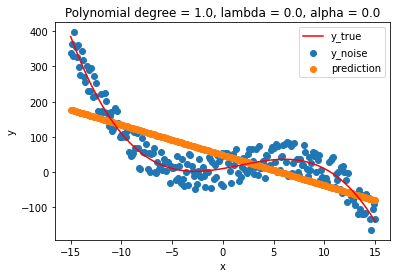

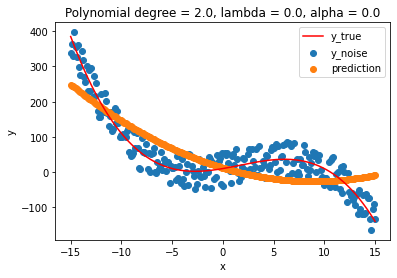

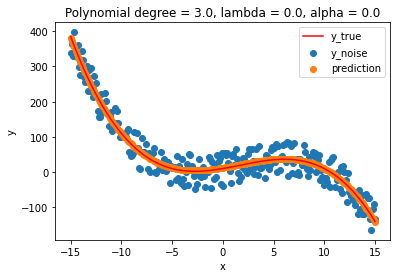

In [8]:
for i in np.arange(1, 4):
    plot_poly_expansion(float(i), spark_df)

The next cell uses L2 regularization to avoid overfitting.  Note how the prediction no longer exactly follows y_true.

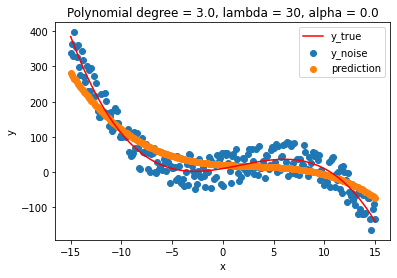

In [9]:
# try some regularization on the heavily overfit case of poly expansion = 3
fit, pipe = plot_poly_expansion(3., spark_df, lambda_reg=30)

The following cell shows how a range of regularization parameters affects the fit.  Bigger regularization values leads to more model bias and less variance.

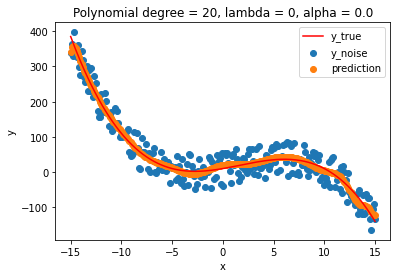

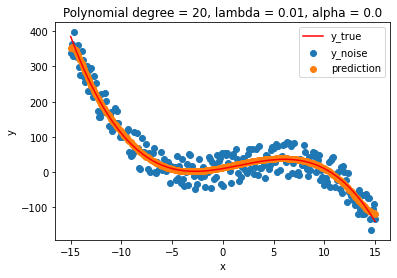

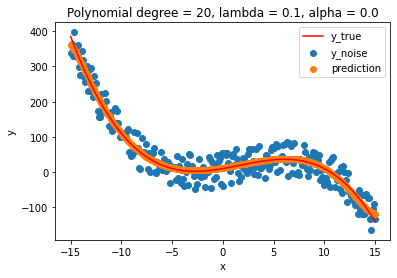

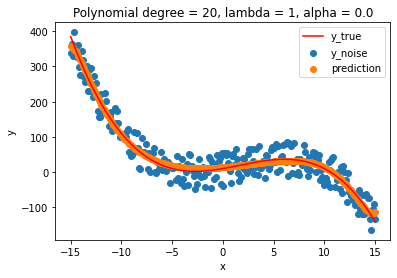

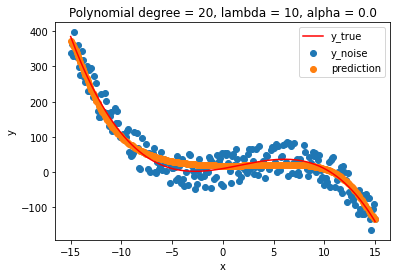

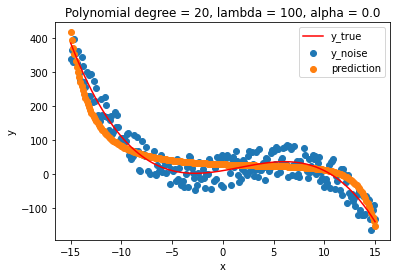

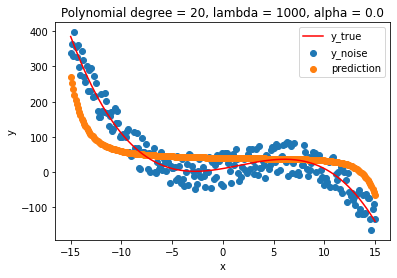

In [10]:
# define a list of regularization params list and number of polynomial expansion params
reg_params = [0, 0.01, 0.1, 1, 10, 100, 1000]
num_params = 20

# define a list to store coefficients 
coef_list = []

# for each regularization param
for reg in reg_params:
    # fit and plot the model
    fit, pipe = plot_poly_expansion(num_params, spark_df, reg)
    
    # append the model coefficients to the list
    coef_list.append(pipe.stages[-1].coefficients.toArray())

The plot below shows how the regression coefficients shrink towards 0 as the L2 regularization parameter lambda is increased.  The large Y scale shows how coefficients that start out far away from 0 shrink towards 0. The small Y scall shows that there are coefficients that start out close to 0 and also shrink towards 0. 

(7, 20)


Text(0, 0.5, 'Coefficient')

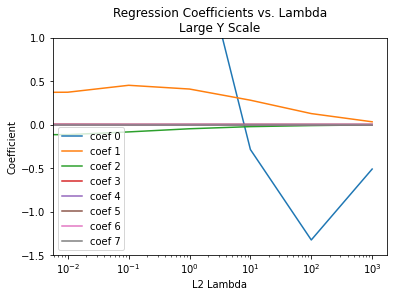

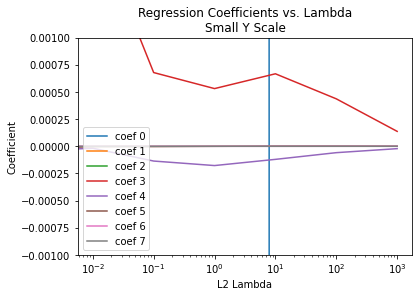

In [11]:
coef_array = np.array(coef_list)
print(coef_array.shape)
plt.figure()
for i in np.arange(8):
    plt.semilogx(reg_params, coef_array[:,i], label="coef %s" % i)
plt.ylim(-1.5, 1)
plt.legend()
plt.title("Regression Coefficients vs. Lambda\nLarge Y Scale")
plt.xlabel("L2 Lambda")
plt.ylabel("Coefficient")

plt.figure()
for i in np.arange(8):
    plt.semilogx(reg_params, coef_array[:,i], label="coef %s" % i)
#plt.ylim(-1.5, 1)
plt.ylim(-.001, .001)
plt.legend()
plt.title("Regression Coefficients vs. Lambda\nSmall Y Scale")
plt.xlabel("L2 Lambda")
plt.ylabel("Coefficient")